In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from model import Classifier
from preprocessing import Create_Matrix, StandardScaler, Split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
timesteps = 90
batch_size = 512
epochs = 400

In [3]:
sample = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date']).fillna(method='ffill').values

In [4]:
label=[0]
for i in range(sample.shape[0]-1):
    if sample[i] < sample[i+1]:
        label.append(1)
    else:
        label.append(0)

In [5]:
x = []
y = []
for i in range(timesteps, sample.shape[0]):
    x.append(sample[i-timesteps:i])
    y.append(label[i])
x = np.array(x).reshape(-1, 45, 1, 2)
y = np.array(y).reshape(-1, 1)

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

In [7]:
train = pd.DataFrame(columns=(['chance']), data=y_train) 
train.to_csv('train.csv', index=False, header=True)

In [8]:
scaler = StandardScaler(x_train.reshape(-1))
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [9]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [10]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = Classifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [12]:
history = dict()
history['loss'] = []
history['val_loss'] = []
best_model = np.inf
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_val)
        val_loss = criterion(y_pred, y_val)
        loss = loss.item()
        val_loss = val_loss.item()
    print(f'Epoch:{1+epoch:03d}-loss:{loss:.5f}-val_loss:{val_loss:.5f}')
    if val_loss <= best_model:
        best_model = val_loss
        torch.save(model, 'checkpoint.pt')
        print('weight_saved')
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
model = torch.load('checkpoint.pt')

Epoch:001-loss:0.63483-val_loss:0.64337
weight_saved
Epoch:002-loss:0.61058-val_loss:0.64517
Epoch:003-loss:0.63248-val_loss:0.64360
Epoch:004-loss:0.61459-val_loss:0.64332
weight_saved
Epoch:005-loss:0.64863-val_loss:0.64291
weight_saved
Epoch:006-loss:0.64921-val_loss:0.64338
Epoch:007-loss:0.63174-val_loss:0.64177
weight_saved
Epoch:008-loss:0.62952-val_loss:0.64064
weight_saved
Epoch:009-loss:0.63908-val_loss:0.64029
weight_saved
Epoch:010-loss:0.61939-val_loss:0.64246
Epoch:011-loss:0.64165-val_loss:0.63978
weight_saved
Epoch:012-loss:0.62990-val_loss:0.64022
Epoch:013-loss:0.65470-val_loss:0.64140
Epoch:014-loss:0.67633-val_loss:0.63894
weight_saved
Epoch:015-loss:0.63173-val_loss:0.63564
weight_saved
Epoch:016-loss:0.61851-val_loss:0.63748
Epoch:017-loss:0.61641-val_loss:0.63200
weight_saved
Epoch:018-loss:0.62047-val_loss:0.63458
Epoch:019-loss:0.62035-val_loss:0.63097
weight_saved
Epoch:020-loss:0.62414-val_loss:0.63769
Epoch:021-loss:0.59997-val_loss:0.62963
weight_saved
Epoc

Epoch:198-loss:0.36036-val_loss:0.55469
Epoch:199-loss:0.38816-val_loss:0.57038
Epoch:200-loss:0.40377-val_loss:0.55989
Epoch:201-loss:0.37049-val_loss:0.54960
Epoch:202-loss:0.33531-val_loss:0.53404
Epoch:203-loss:0.36584-val_loss:0.54448
Epoch:204-loss:0.36814-val_loss:0.53618
Epoch:205-loss:0.41379-val_loss:0.54071
Epoch:206-loss:0.39903-val_loss:0.53973
Epoch:207-loss:0.34714-val_loss:0.55903
Epoch:208-loss:0.33917-val_loss:0.54887
Epoch:209-loss:0.35462-val_loss:0.55550
Epoch:210-loss:0.34170-val_loss:0.55193
Epoch:211-loss:0.32922-val_loss:0.53343
Epoch:212-loss:0.38385-val_loss:0.52751
weight_saved
Epoch:213-loss:0.32027-val_loss:0.59305
Epoch:214-loss:0.38550-val_loss:0.54657
Epoch:215-loss:0.31806-val_loss:0.53586
Epoch:216-loss:0.36217-val_loss:0.54610
Epoch:217-loss:0.39505-val_loss:0.54057
Epoch:218-loss:0.36425-val_loss:0.54439
Epoch:219-loss:0.36652-val_loss:0.53845
Epoch:220-loss:0.34158-val_loss:0.54765
Epoch:221-loss:0.39040-val_loss:0.52760
Epoch:222-loss:0.34017-val_

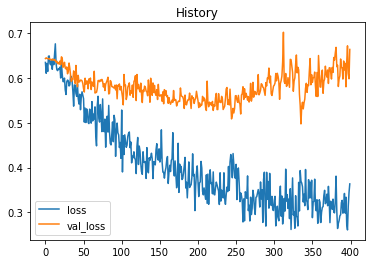

In [13]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('History')
plt.legend()
plt.show()

In [14]:
with torch.no_grad():
    model.eval()
    pred = model(x_test)
    pred = pred.cpu().numpy()
test = []
for i in pred:
    if i < 0.5:
        test.append(0)
    else:
        test.append(1)
metrics.accuracy_score(y_test, test)

0.76

In [15]:
with torch.no_grad():
    model.eval()
    pred = model(x_val)
    pred = pred.cpu().numpy()
val = []
for i in pred:
    if i < 0.5:
        val.append(0)
    else:
        val.append(1)

In [16]:
val = pd.DataFrame(columns=(['chance']), data=val) 
val.to_csv('val.csv', index=False, header=True)
test = pd.DataFrame(columns=(['chance']), data=test) 
test.to_csv('test.csv', index=False, header=True)